In [1]:
import pandas as pd
import math
import keras
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import save_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from pickle import dump,load
import warnings
warnings.simplefilter("ignore", UserWarning)

<ipython-input-1-c3954ec604e3>:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

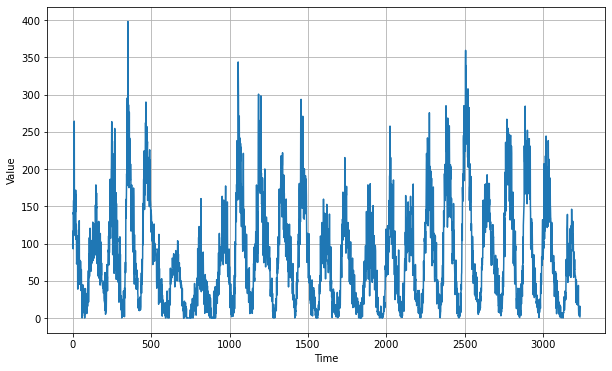

In [3]:
import csv
time_step = []
sunspots = []

with open('./Sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [4]:
series

array([ 96.7, 104.3, 116.7, ...,  13.2,  15.9,   1.6])

In [5]:
split_time = 3000
Y_train = time[:split_time]
X_train = series[:split_time]
Y_test = time[split_time:]
X_test = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [6]:
def build_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('conv_filter',min_value=30,max_value=120,default=60,step=10), 
                     kernel_size=hp.Choice('conv_kernel',values=[3,5],default=5),
                     strides=1, 
                     padding="causal",
                     activation=hp.Choice('conv_activation',values=['relu','sigmoid'],default='relu'),
                     input_shape=[None,1]))
#     model.add(LSTM(hp.Int('LSTM_layer_1',min_value=30,max_value=120,default=60,step=10), return_sequences=True))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=30,max_value=240,default=60,step=10),return_sequences=True))
#     model.add(LSTM(hp.Int('LSTM_layer_2',min_value=30,max_value=120,default=60,step=10), return_sequences=True))
    model.add(Dense(hp.Int('Dense_layer_1',min_value=20,max_value=40,default=30,step=5), 
                    activation=hp.Choice('dense_activation_1',values=['relu','sigmoid'],default='relu')))
    model.add(Dense(hp.Int('Dense_layer_1',min_value=10,max_value=30,default=10,step=5), 
                    activation=hp.Choice('dense_activation_2',values=['relu','sigmoid'],default='relu')))
    model.add(Dense(1))
    model.add(Lambda(lambda x: x * 400))
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer,
                  metrics=["mse"])
    return model

In [7]:
# def build_model(hp):
#     model = Sequential()
#     model.add(Conv1D(filters=hp.Int('conv_filter',min_value=30,max_value=120,default=60,step=10), 
#                      kernel_size=hp.Choice('conv_kernel',values=[3,5],default=5),
#                      strides=1, 
#                      padding="causal",
#                      activation=hp.Choice('conv_activation',values=['relu','sigmoid'],default='relu'),
#                      input_shape=[None,1]))
#     model.add(LSTM(hp.Int('LSTM_layer_1',min_value=30,max_value=120,default=60,step=10), return_sequences=True))
#     model.add(LSTM(hp.Int('LSTM_layer_2',min_value=30,max_value=120,default=60,step=10), return_sequences=True))
#     model.add(Dense(hp.Int('Dense_layer_1',min_value=20,max_value=40,default=30,step=5), 
#                     activation=hp.Choice('dense_activation_1',values=['relu','sigmoid'],default='relu')))
#     model.add(Dense(hp.Int('Dense_layer_1',min_value=10,max_value=30,default=10,step=5), 
#                     activation=hp.Choice('dense_activation_2',values=['relu','sigmoid'],default='relu')))
#     model.add(Dense(1))
#     model.add(Lambda(lambda x: x * 400))
#     optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
#     model.compile(loss=tf.keras.losses.Huber(),
#                   optimizer=optimizer,
#                   metrics=["mse"])
#     return model

In [8]:
tuner= RandomSearch(
        build_model,
        objective='mse',
        max_trials=2,
        executions_per_trial=1,
        directory='my_dir',
        project_name='lstm_04'
        )

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [10]:
window_size=125
batch_size=250
train_set = windowed_dataset(X_train, window_size, batch_size, shuffle_buffer_size)

In [11]:
tuner.search(
        train_set,
        epochs=500
)

Trial 2 Complete [00h 02m 30s]
mse: 515.5499877929688

Best mse So Far: 515.5499877929688
Total elapsed time: 00h 05m 39s
INFO:tensorflow:Oracle triggered exit


In [12]:
best_model = tuner.get_best_models(num_models=1)[0]

In [13]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [14]:
rnn_forecast = model_forecast(best_model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1,0]

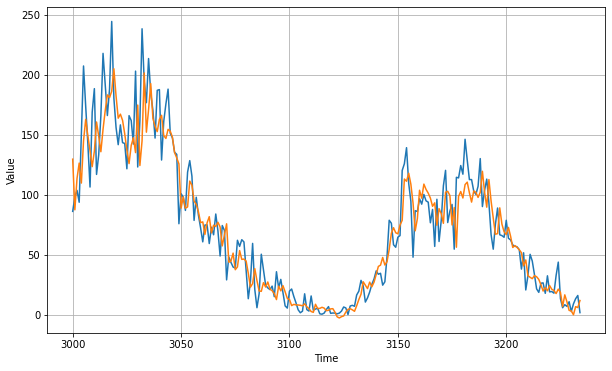

In [15]:
plt.figure(figsize=(10, 6))
plot_series(Y_test, X_test)
plot_series(Y_test, rnn_forecast)

In [16]:
tf.keras.metrics.mean_absolute_error(X_test, rnn_forecast).numpy()

14.595829